# Getting started with TinyTimeMixer (TTM) with Channel-Mix Finetuning

This notebooke demonstrates the usage of finetuning a pre-trained `TinyTimeMixer` model with channel-mix finetuning. In channel-mix finetuning, we forecast the target_values based on the past values of the target columns and conditional columns and mixing them.


For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune**: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the values mentioned in `conditional_columns` as features for channel mixing. Search for `# ch_mix:` keyword for important parameters to edit for channel mixing finetuning. Set decoder_mode to "mix_channel" for channel-mix finetuning.


Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

# Getting started with TinyTimeMixer (TTM) with Channel-Mix Finetuning

This notebook demonstrates the usage of finetuning a pre-trained `TinyTimeMixer` model with channel-mix finetuning. In channel-mix finetuning, we forecast the target_values based on the past values of the target columns and conditional columns and mixing them.

For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model and apply it to a high-dimensional Ecoli dataset. The goal is to test the ability of this foundational model to handle such data. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Fine-tune**: The pre-trained TTM will be quickly fine-tuned onthe `train` split of the target data, and subsequently, evaluated on the `test` part of the target data. During finetuing, we used the values mentioned in `conditional_columns` as features for channel mixing. Search for `# ch_mix:` keyword for important parameters to edit for channel mixing finetuning. Set decoder_mode to "mix_channel" for channel-mix finetuning.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

## Installation

In [2]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git"

  Cloning https://github.com/ibm-granite/granite-tsfm.git to /tmp/pip-install-abzz3o4b/granite-tsfm_55826148e9134f0796f1fb2d58c3d4c7
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-abzz3o4b/granite-tsfm_55826148e9134f0796f1fb2d58c3d4c7
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 5f1f6e6c949147cc186c9a6e851c5ff831b83f10
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 139.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.

## Imports

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
import pandas as pd

# Load the CSV file from Google Drive
file_path = "/content/drive/MyDrive/Ecoli data/exp1224.csv"
try:
    df_test = pd.read_csv(file_path)
    display(df_test.head())
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

,rihC,ypfH,alsI,ygdQ,yabP,ypfJ,talB,yqeI,yabI,hda,...,rpoD,fimD,lacZ,yacH,U66,serA,U139,tdcG_2,infA,yebF
0,-0.022629,0.148508,-0.088955,-0.232066,0.069350,-0.644056,-0.030329,-0.020271,0.158288,1.246769,...,-0.084612,-0.012124,-0.064123,-0.065857,-0.063226,2.938553,-0.079553,-0.094431,-3.164757,-0.242952
1,-0.075618,-0.191642,-0.041127,0.221798,0.114038,-0.554063,-0.029043,0.117677,0.020580,1.160078,...,-0.051237,-0.009570,-0.067436,-0.047152,-0.096200,3.144924,-0.022218,-0.034728,-1.831284,0.094008
2,0.053473,0.146480,-0.111173,0.138315,0.002590,-0.147216,-0.113246,-0.030373,0.089998,1.312099,...,-0.020321,-0.031348,-0.067067,0.027820,-0.080628,3.385740,-0.017088,-0.034646,-3.035438,-0.126263
3,-0.137537,-0.224630,-0.055299,0.019529,0.085433,-0.508369,0.011168,-0.104683,0.235458,0.657336,...,-0.018129,-0.012545,-0.007957,-0.086683,-0.067020,2.658177,-0.048128,-0.101937,-2.332679,0.168084
4,-0.001089,0.149665,0.019627,0.292656,-0.153317,-0.116954,-0.076620,-0.048036,0.044441,1.461989,...,-0.072185,-0.016076,-0.097118,-0.055341,-0.110282,2.639522,-0.048160,-0.161916,-1.510021,0.566953


In [10]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

## Important arguments

In [28]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Ecoli Data
DATA_ROOT_PATH = "/content/drive/MyDrive/Ecoli data/exp1224.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"


# Forecasting parameters
context_length = 512
forecast_length = 96

## Data processing pipeline

In [42]:
# Load the data file and see the columns

# timestamp_column = "timestamp"
id_columns = []


data = pd.read_csv(
    DATA_ROOT_PATH
)

# Assuming the first column can be used as a form of identifier if needed, otherwise keep id_columns empty.
# If there's a relevant time column, replace "your_time_column" with its name.
# If there's no time column, you might need to create one based on the data's nature.
# For this Ecoli data, it seems there's no explicit time or ID column for time series.
# We'll proceed assuming each row is a time point and columns are features.

# data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Reset the index to ensure the hours are correctly assigned, as hour information is missing in the original timestamp of this df
# data[timestamp_column] = data[timestamp_column] + pd.to_timedelta(
#     data.groupby(data[timestamp_column].dt.date).cumcount(), unit="h"
# )


print(data.head())

# exog: Mention Exog channels in control_columns and target in target_columns

# Since the Ecoli data is gene expression and doesn't fit the typical time series forecasting
# structure with target and conditional columns like the bike sharing data,
# we'll adjust column_specifiers accordingly.
# You might need to define target and conditional columns based on your specific task
# if it's different from the original notebook's forecasting task.

column_specifiers = {
    # "timestamp_column": timestamp_column, # No clear timestamp in the provided data head
    "id_columns": id_columns, # No clear ID columns
    # Assuming all columns are features for now. You might need to adjust this
    # based on your specific task and which columns are targets/conditionals.
    "target_columns": data.columns.tolist(), # Assuming all columns are potential targets
    "conditional_columns": [], # No explicit conditional columns based on data head
}

split_params = {"train": [0, 0.8], "valid": [0.8, 1], "test": [0.8, 1]}

       rihC      ypfH      alsI      ygdQ      yabP      ypfJ      talB  \
0 -0.022629  0.148508 -0.088955 -0.232066  0.069350 -0.644056 -0.030329   
1 -0.075618 -0.191642 -0.041127  0.221798  0.114038 -0.554063 -0.029043   
2  0.053473  0.146480 -0.111173  0.138315  0.002590 -0.147216 -0.113246   
3 -0.137537 -0.224630 -0.055299  0.019529  0.085433 -0.508369  0.011168   
4 -0.001089  0.149665  0.019627  0.292656 -0.153317 -0.116954 -0.076620   

       yqeI      yabI       hda  ...      rpoD      fimD      lacZ      yacH  \
0 -0.020271  0.158288  1.246769  ... -0.084612 -0.012124 -0.064123 -0.065857   
1  0.117677  0.020580  1.160078  ... -0.051237 -0.009570 -0.067436 -0.047152   
2 -0.030373  0.089998  1.312099  ... -0.020321 -0.031348 -0.067067  0.027820   
3 -0.104683  0.235458  0.657336  ... -0.018129 -0.012545 -0.007957 -0.086683   
4 -0.048036  0.044441  1.461989  ... -0.072185 -0.016076 -0.097118 -0.055341   

        U66      serA      U139    tdcG_2      infA      yebF  
0 -0

In [43]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    data,
    split_params,
)

/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/dataset.py:220: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df["group"] = 0  # create a artificial group
/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/dataset.py:220: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df["group"] = 0  # create a artificial group
/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/dataset.py:220: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [44]:
train_dataset[3]

{'past_values': tensor([[-0.9765, -0.9715, -0.2563,  ..., -0.7720, -1.0569,  0.3070],
         [ 0.2140,  0.9706,  0.4121,  ..., -1.4012, -0.4754,  1.1777],
         [-1.1734,  0.6134, -0.0173,  ..., -0.2166, -0.6568,  1.5244],
         ...,
         [ 0.3183, -0.4888,  1.0576,  ...,  1.1925,  0.0263,  0.3266],
         [ 0.5566,  1.0922,  0.7043,  ..., -0.0386,  0.4482,  0.0663],
         [ 0.4387,  0.5383,  0.5697,  ...,  0.0505,  1.2798,  0.2847]]),
 'future_values': tensor([[ 0.6262,  1.0559, -0.4046,  ...,  0.2374,  1.1556,  0.8763],
         [-0.1273,  0.3360,  0.2737,  ..., -0.1262,  1.1584,  0.6788],
         [ 0.6797,  0.1952,  1.1027,  ..., -0.1396,  0.6972,  1.0742],
         ...,
         [-0.4895, -0.8049, -0.2068,  ...,  0.2863, -0.3147,  0.2448],
         [-0.5592, -0.9149, -0.1899,  ...,  0.3180, -0.3785, -0.1304],
         [-0.5256, -0.9383, -0.5888,  ..., -0.4927, -0.0493,  0.2171]]),
 'past_observed_mask': tensor([[True, True, True,  ..., True, True, True],
         

## Zero-shot evaluation method

In [45]:
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"

zeroshot_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
zeroshot_model

INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r1
INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r1, revision = main.
INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:[TTM] context_length = 512, prediction_length = 96


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [46]:
tsp.prediction_channel_indices

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [47]:
tsp.num_input_channels

1807

In [48]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

In [49]:
zeroshot_trainer.evaluate(test_dataset)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohammednagdi4 (mohammednagdi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 2.2631335258483887,
 'eval_model_preparation_time': 0.0035,
 'eval_runtime': 5.7995,
 'eval_samples_per_second': 10.863,
 'eval_steps_per_second': 0.172}

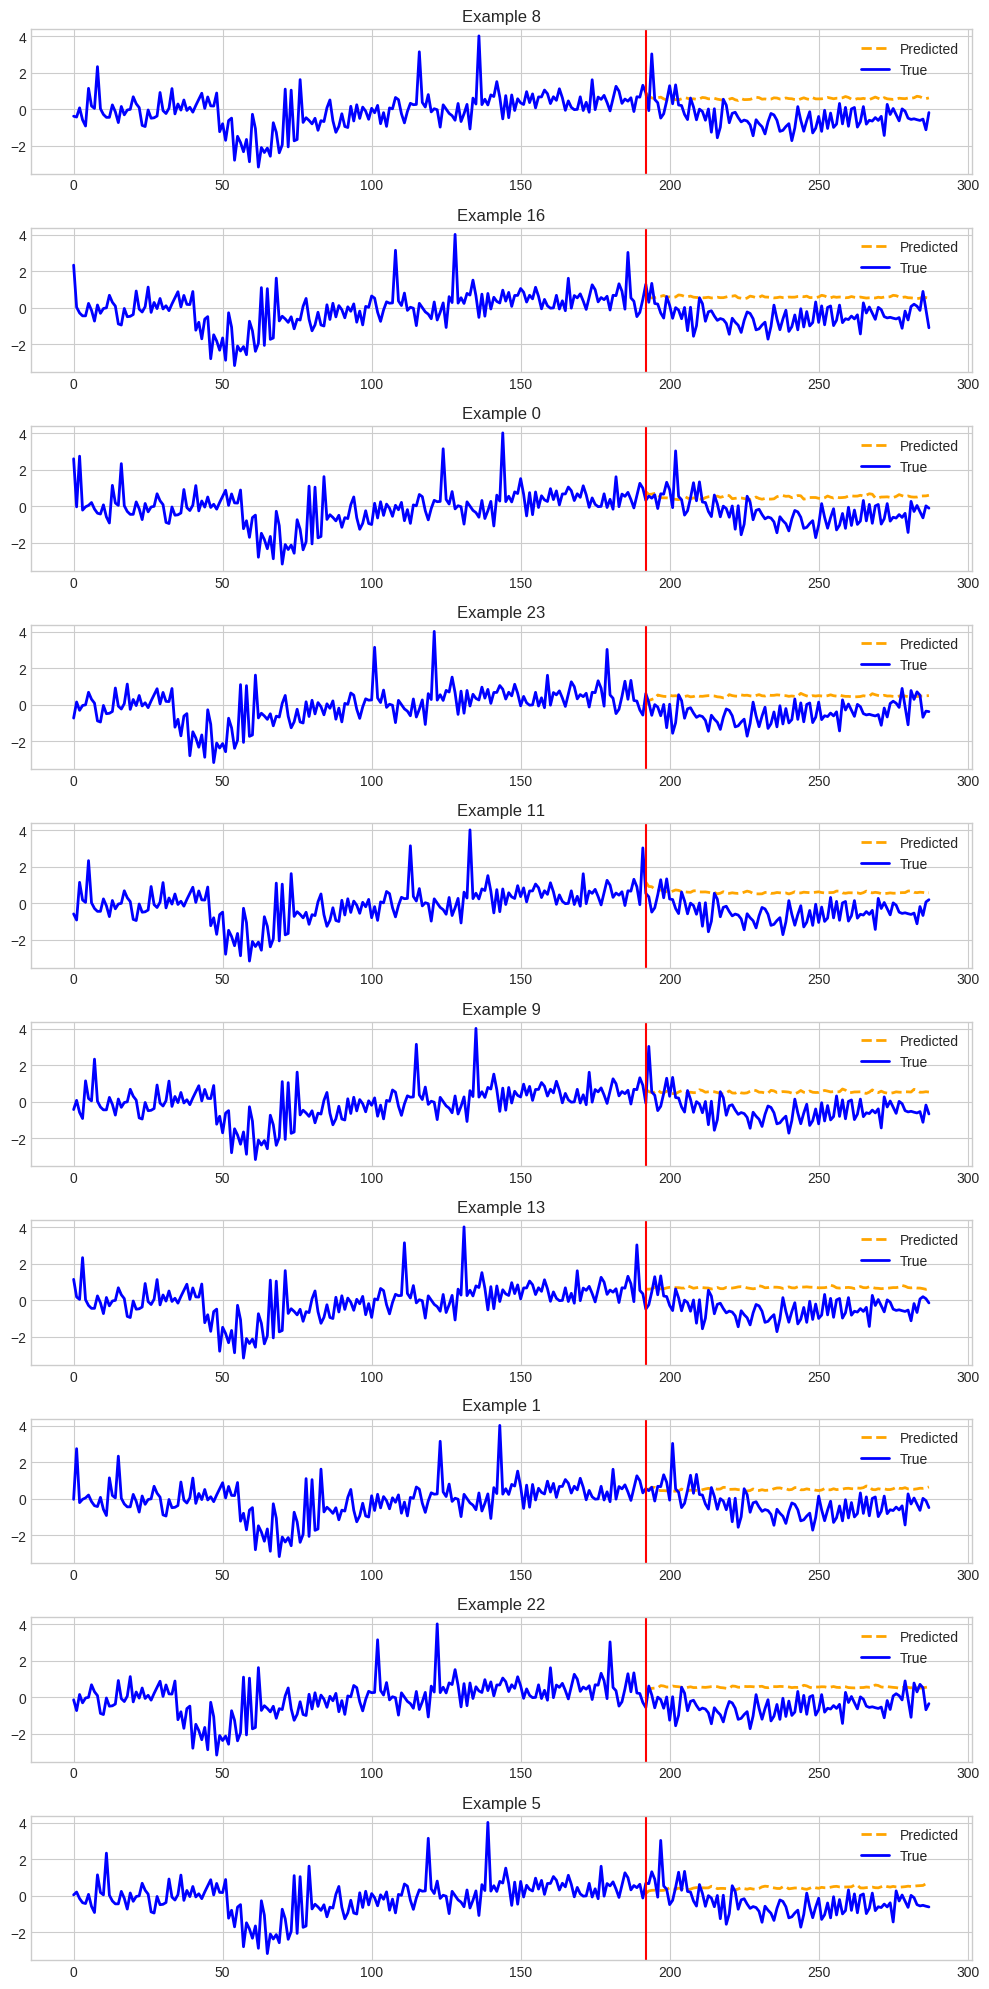

In [50]:
# plot
plot_predictions(
    model=zeroshot_trainer.model,
    dset=train_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_zeroshot",
    channel=0,
)

 ## Few-shot finetune and evaluation method

### Load model
Optionally, we can change some parameters of the model, e.g., dropout of the head.

In [54]:
finetune_forecast_model = get_model(
    TTM_MODEL_PATH,
    context_length=context_length,
    prediction_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # ch_mix:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
)
finetune_forecast_model

INFO:/usr/local/lib/python3.12/dist-packages/tsfm_public/toolkit/get_model.py:Loading model from: ibm-granite/granite-timeseries-ttm-r1
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r1 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.m

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

### Frezze the TTM backbone

In [55]:
print(
    "Number of params before freezing backbone",
    count_parameters(finetune_forecast_model),
)

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 33472738
Number of params after freezing the backbone 32957154


### Finetune model with decoder mixing and exog fusion

In [56]:
# Important parameters
num_epochs = 20  # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=False,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

OPTIMAL SUGGESTED LEARNING RATE = 6.73415065775082e-05


In [58]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 6.73415065775082e-05


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.292700,2.263797
2,1.292200,2.262600
3,1.291300,2.259750
4,1.282900,2.255151
5,1.273600,2.249074
6,1.261300,2.242194
7,1.242700,2.235167
8,1.226400,2.228258
9,1.211000,2.221707
10,1.196100,2.215699


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: T

[TrackingCallback] Mean Epoch Time = 4.801497268676758 seconds, Total Train Time = 332.11642265319824


TrainOutput(global_step=20, training_loss=1.2002623677253723, metrics={'train_runtime': 332.0832, 'train_samples_per_second': 1.506, 'train_steps_per_second': 0.06, 'total_flos': 9.2905324901376e+16, 'train_loss': 1.2002623677253723, 'epoch': 20.0})

In [59]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 2.1936144828796387,
 'eval_runtime': 6.9553,
 'eval_samples_per_second': 9.058,
 'eval_steps_per_second': 0.144,
 'epoch': 20.0}

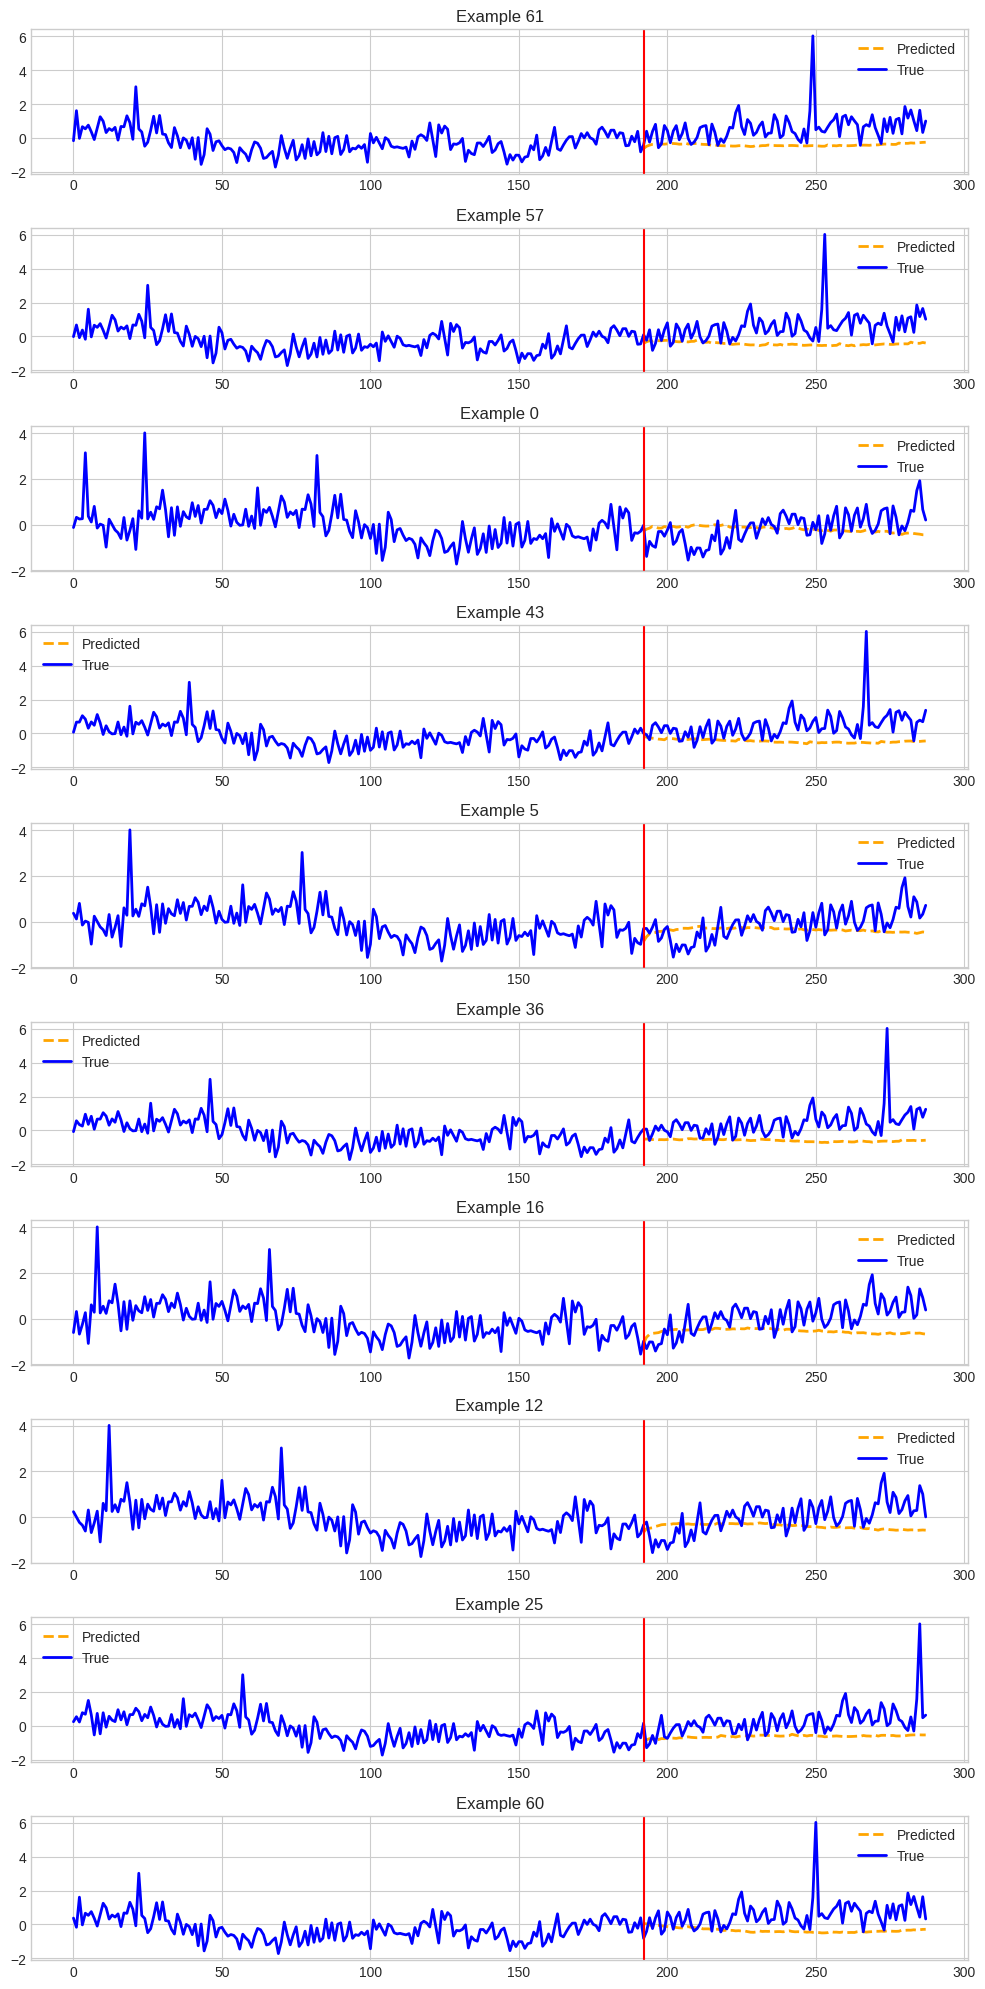

In [60]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, "bike_sharing"),
    plot_prefix="test_finetune",
    channel=0,
)